## Première partie : constitution du dataset principal

### 🧱 Mise en contexte

Afin de mener à bien l’exercice de backtesting comparatif entre différents systèmes de retraite (par répartition et par capitalisation), il était indispensable de constituer un dataset solide et cohérent retraçant les performances historiques des principaux indices boursiers, depuis 1985.  
L’objectif : simuler un investissement régulier (type DCA) dans des portefeuilles représentatifs sur une très longue période.

Pour cela, les données ont été collectées via l’API `yfinance`, qui fournit les historiques mensuels des indices comme :
- le **CAC 40**,
- le **S&P 500**,
- le **FTSE 100**,

Cependant, cette approche s’est heurtée à plusieurs obstacles :
- **des trous dans les séries temporelles**,
- **l’absence d’indices en version “Total Return”** (dividendes réinvestis),
- et surtout, **l’absence de données pour les trois premières années du CAC 40 TR et du S&P 500 TR**, deux indices essentiels à l’analyse.

Il a donc fallu reconstruire ces données manquantes à l’aide de méthodes statistiques, tout en garantissant la cohérence économique des résultats.

---

### ⚙️ Choix méthodologique pour le backfilling des valeurs manquantes

Plusieurs approches ont été testées pour combler les données manquantes du **CAC 40 TR** et du **S&P 500 TR** (1985–1987), notamment :
- des modèles de **régression linéaire**,
- des **Random Forest Regressors**,
- et des modèles de séries temporelles comme **ARIMA** ou **Prophet**.

> 🔬 **Constat** : malgré des scores de validation très élevés (R² proches de 1, faibles écarts-types), les résultats générés étaient souvent incohérents sur le plan économique, avec des **valeurs aberrantes ou des discontinuités non réalistes**.

---

### ✅ Méthode retenue : une approche hybride simple et robuste

Pour garantir la continuité et la crédibilité du dataset, une méthode alternative a été privilégiée. Elle repose sur deux étapes complémentaires :

#### 1. **Méthode par ratio historique**
- Calcul du **ratio moyen de performance** entre :
  - `S&P 500 PR` et `S&P 500 TR` (≈ 0.99),
  - `S&P 500 PR` et `CAC 40 TR` (≈ 0.83).
- Application de ce ratio aux valeurs du `S&P 500 PR` avant 1988, afin d’estimer les valeurs manquantes du `TR`.

> Avantage : cohérence structurelle, variation réaliste.  
> Inconvénient : **volatilité exagérée** lors de fortes hausses de marché.

#### 2. **Méthode par rendement mensuel moyen**
- Calcul de la **performance mensuelle moyenne composée** sur la période connue.
- Application de ce rendement à une base 1, puis remise à l’échelle sur la valeur connue de 1988.

> Avantage : continuité parfaite, aucun saut.  
> Inconvénient : **lissage excessif**, perte de la volatilité naturelle des marchés.

---

### 🧪 Méthode finale : une hybridation des deux approches

> Un **moyenne non pondérée** des deux méthodes a été utilisée, permettant :
> - d’atténuer la volatilité exagérée de la méthode par ratio,
> - d’éviter le caractère trop lisse de la méthode par performance moyenne.

Ce choix méthodologique permet :
- une reconstitution **sans discontinuité ni valeurs aberrantes**,
- une trajectoire crédible et économiquement interprétable,
- et une cohérence avec les performances long terme connues des indices étudiés.

---

### 🎯 Conclusion

Ce compromis méthodologique ne vise pas la précision absolue, mais la **robustesse sur 40 ans de simulation**, dans le cadre d’un modèle de retraite capitalisé.  
Il constitue une **base fiable** pour les calculs à venir, tout en restant **simple, explicable, et reproductible**.

L’analyse du portefeuille simulé sera détaillée dans un second notebook, sur la base de ce dataset désormais reconstitué.


In [156]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [157]:
# Définition des dates de début et de fin
start_date = "1980-01-01"
end_date = "2024-12-31"

# Pour évité de répéter les appels API, les données utiles on été éxtraites puis stocker sur la machine
'''# Téléchargement des données historiques du CAC 40 et du S&P 500 depuis Yahoo Finance
CAC40 = yf.download("^FCHI", start=start_date, end=end_date, interval="1mo")["Open"]         # Indice CAC40 PR   = Price Return = Dividendes non réinvestis
CAC40_TR = yf.download("PX1GR.PA", start=start_date, end=end_date, interval="1mo")["Open"]   # Indice CAC40 TR   = Total Return = Dividendes réinvestis
sp500 = yf.download("^GSPC", start=start_date, end=end_date, interval="1mo")["Open"]         # Indice CAC40 PR   = Price Return = Dividendes non réinvestis
sp500_TR = yf.download("^SP500TR", start=start_date, end=end_date, interval="1mo")["Open"]   # Indice sp500 TR   = Total Return = Dividendes réinvestis
FTSE100 = yf.download("^FTSE", start=start_date, end=end_date, interval="1mo")["Open"]       # Indice FTSE100 PR = Price Return = Dividendes non réinvestis

# Garder uniquement les prix d'ouverture et renommer
CAC40 = CAC40[['^FCHI']].rename(columns={'^FCHI': "CAC40"})
CAC40_TR = CAC40_TR[['PX1GR.PA']].rename(columns={'PX1GR.PA': "CAC40_TR"})
sp500 = sp500[['^GSPC']].rename(columns={'^GSPC': "SP500_PR"})
sp500_TR = sp500_TR[['^SP500TR']].rename(columns={'^SP500TR': "SP500_TR"})
FTSE100 = FTSE100[['^FTSE']].rename(columns={'^FTSE': "FTSE100_PR"})'''

# Importer et convertir les data de yahoo finance
CAC40 = pd.read_csv(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites\data\raw\CAC40.csv",
                    index_col='Date', parse_dates=['Date'])         # Indice CAC40 PR   = Price Return = Dividendes non réinvestis
CAC40_TR = pd.read_csv(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites\data\raw\CAC40_TR.csv",
                       index_col='Date', parse_dates=['Date'])   # Indice CAC40 TR   = Total Return = Dividendes réinvestis
sp500 = pd.read_csv(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites\data\raw\sp500.csv",
                    index_col='Date', parse_dates=['Date'])         # Indice CAC40 PR   = Price Return = Dividendes non réinvestis
sp500_TR = pd.read_csv(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites\data\raw\sp500_TR.csv",
                       index_col='Date', parse_dates=['Date'])   # Indice sp500 TR   = Total Return = Dividendes réinvestis
FTSE100 = pd.read_csv(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites\data\raw\FTSE100.csv",
                      index_col='Date', parse_dates=['Date'])       # Indice FTSE100 PR = Price Return = Dividendes non réinvestis


# Importer, renommer et convertir le fichier du World Government Bond Index
WGBI = pd.read_csv(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites\data\raw\WGBI.csv")      # Indice WGBI TR     = Total Return = Coupons réinvestis
WGBI.rename(columns={"FTSE World Government Bond - Developed Markets": "WGBI_TR"}, inplace=True)
WGBI["Date"] = pd.to_datetime(WGBI["Date"], format="%m/%Y")
WGBI = WGBI[WGBI["Date"] <= pd.to_datetime(end_date)]
WGBI.set_index("Date", inplace=True)

# Importer, renommer et convertir le CAC 40 Gross Revenue 2015/2025 (le cac50 Total Return de yahou finance s'arrete en 2015)
CAC40_TR_ = pd.read_csv(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites\data\raw\CAC40GROSSTR_2025-03-21_X.csv")      # Indice WGBI TR     = Total Return = Coupons réinvestis
CAC40_TR_.rename(columns={"ouv": "CAC40_TR_"}, inplace=True)
CAC40_TR_["Date"] = pd.to_datetime(CAC40_TR_["date"], format="%d/%m/%Y")
CAC40_TR_ = CAC40_TR_.drop(columns=["date","haut","bas","clot","vol","devise"])
CAC40_TR_ = CAC40_TR_[CAC40_TR_["Date"] <= pd.to_datetime(end_date)]
CAC40_TR_.set_index("Date", inplace=True)
CAC40_TR_ = CAC40_TR_.resample("MS").first()

# Fusionner les indices sur la base des dates
df = pd.concat([CAC40_TR, CAC40_TR_, sp500_TR, sp500, FTSE100, WGBI["WGBI_TR"]], axis=1, join="outer")

# Confirmation dqu l'index est bien en datetime
df.index = pd.to_datetime(df.index)

In [158]:
# Problème de qualité des données, les valeur communes ne sont pas strictement identiques, cela est du à des aproximation du passage aux perf mensuels

# # Filtrer les lignes où les deux colonnes ne sont pas nulles
df_common = df[df["CAC40_TR"].notna() & df["CAC40_TR_"].notna()]
df_common = df_common.drop(columns=["SP500_TR","SP500_PR","FTSE100_PR","WGBI_TR"])
df_common["ratio_TR"] = df_common["CAC40_TR_"] / df_common["CAC40_TR"]
# Affichage pour vérification
df_common

,CAC40_TR,CAC40_TR_,ratio_TR
Date,,,
2015-03-01,11337.700195,11723.71,1.034047
2015-04-01,11692.099609,11570.65,0.989613
2015-05-01,11712.099609,11744.58,1.002773
2015-06-01,11819.400391,11828.24,1.000748
2015-07-01,11542.500000,11462.72,0.993088
2015-08-01,12111.400391,12007.99,0.991462
2015-09-01,10741.099609,10847.90,1.009943
2015-10-01,10485.400391,10702.10,1.020667
2015-11-01,11654.900391,11495.24,0.986301


In [159]:
# Calcul du ratio, puis application sur le plus petit des deux jeux de données
mean_ratio = df_common["ratio_TR"].mean()
print(f"Différence moyenne entre les valeur communes de {1-mean_ratio}")

CAC40_TR_scaled = df["CAC40_TR_"] / mean_ratio
df["CAC40_TR_fusion"] = df["CAC40_TR"].combine_first(CAC40_TR_scaled)
df = df.drop(columns=["CAC40_TR","CAC40_TR_"])
df["CAC40_TR"] = df["CAC40_TR_fusion"]
df = df.drop(columns=["CAC40_TR_fusion"])

Différence moyenne entre les valeur communes de -0.003796854033220054


In [160]:
# Définir la dernière date avec des Null, puis diviser les DF en deux (partie complète et partie incomplète)
last_nan_date = df[df.isna().any(axis=1)].index.max()                 # Trouver la dernière date avec au moins un NaN
first_full_date = df[df.index > last_nan_date].dropna().index[0]      # Récupérer la première date après cette dernière date qui a toutes ses colonnes non nulles
from datetime import datetime
print("Première date complète après les NaN :", first_full_date)

# Définir la période connue
start_known = first_full_date
end_known = df.index.max()

df_known = df[df.index >= first_full_date]         # DataFrame sans valeur manquantes
df_to_predict = df[df.index < first_full_date]     # DataFrame à remplir avec le modèle de prédiction

Première date complète après les NaN : 1988-01-01 00:00:00


In [161]:
# Confirmation de la corrélation entre les indice choisis
df_known[["SP500_TR","SP500_PR","CAC40_TR"]].corr()

,SP500_TR,SP500_PR,CAC40_TR
SP500_TR,1.000000,0.996776,0.968203
SP500_PR,0.996776,1.000000,0.978621
CAC40_TR,0.968203,0.978621,1.000000


In [162]:
# Calcul des rendements mensuels moyens
mean_sp500_pr = df['SP500_PR'].pct_change().dropna().mean()
mean_sp500_tr = df_known['SP500_TR'].pct_change().dropna().mean()
mean_cac40_tr = df_known['CAC40_TR'].pct_change().dropna().mean()

# Ratio des rendements moyennes
mean_ratio_snp_pr_tr = mean_sp500_tr / mean_sp500_pr
mean_ratio_snp_cac = mean_cac40_tr / mean_sp500_pr

print(f"Moyenne des rendements mensuels du SNP500 PR : {mean_sp500_pr}")
print(f"Moyenne des rendements mensuels du SNP500 TR : {mean_sp500_tr}")
print(f"Moyenne des rendements mensuels du CAC40 TR : {mean_cac40_tr}")
print(f"Ratio des moyennes mensuelles SNP500 TR / SNP500 PR : {mean_ratio_snp_pr_tr}")
print(f"Ratio des moyennes mensuelles CAC40 TR / SNP500 PR : {mean_ratio_snp_cac}")

#Calcul du rendement perdiode avant "first_full_date" (vérification)
mean_sp500_before = mean_sp500_pr = df_known['SP500_PR'].pct_change().dropna().mean()
print(f"Moyenne des rendements mensuels du SNP500 PR (avant {first_full_date}) : {mean_sp500_before}")

Moyenne des rendements mensuels du SNP500 PR : 0.008524919373678625
Moyenne des rendements mensuels du SNP500 TR : 0.009916236655870332
Moyenne des rendements mensuels du CAC40 TR : 0.008664828732149785
Ratio des moyennes mensuelles SNP500 TR / SNP500 PR : 1.1632059168192852
Ratio des moyennes mensuelles CAC40 TR / SNP500 PR : 1.0164118101695063
Moyenne des rendements mensuels du SNP500 PR (avant 1988-01-01 00:00:00) : 0.008176950480208047


In [163]:
# Création de la colonne de variation mensuel de référence (S&P 500 Price Return)
df['SP500_PR_var_m'] = df['SP500_PR'].pct_change()

# Création des colonnes de variations mensuels estimés (avec le ratio)
df['SP500_TR_var_estimated'] = df['SP500_PR_var_m'] * mean_ratio_snp_pr_tr
df['CAC40_TR_var_estimated'] = df['SP500_PR_var_m'] * mean_ratio_snp_cac

# Initialiser des première valeur connue :
df['SP500_TR_estimated'] = df['SP500_TR']  # Copie de la vraie colonne
df.loc[first_full_date, 'SP500_TR_estimated'] = df.loc[first_full_date, 'SP500_TR']
df['CAC40_TR_estimated'] = df['CAC40_TR']  # Copie de la vraie colonne
df.loc[first_full_date, 'CAC40_TR_estimated'] = df.loc[first_full_date, 'CAC40_TR']

In [164]:
# Création d'une base 1 pour simuler l'évolution relative du CAC40 estimé
df['SP500_base1'] = np.nan
df.loc[df.index.min(), 'SP500_base1'] = 1
df['CAC40_base1'] = np.nan
df.loc[df.index.min(), 'CAC40_base1'] = 1

for i in range(1, len(df.loc[:first_full_date])):
    prev_idx = df.index.get_loc(df.index.min()) + i - 1
    curr_idx = prev_idx + 1
    df.iloc[curr_idx, df.columns.get_loc('SP500_base1')] = (
        df.iloc[prev_idx, df.columns.get_loc('SP500_base1')] * (1 + df.iloc[curr_idx]['SP500_TR_var_estimated'])
    )
    df.iloc[curr_idx, df.columns.get_loc('CAC40_base1')] = (
        df.iloc[prev_idx, df.columns.get_loc('CAC40_base1')] * (1 + df.iloc[curr_idx]['CAC40_TR_var_estimated'])
    )
# Remise à l'échelle sur les valeurs connues
scaling_factor = df.loc[first_full_date, 'SP500_TR'] / df.loc[first_full_date, 'SP500_base1']
df['SP500_TR_ratio'] = df['SP500_base1'] * scaling_factor
scaling_factor = df.loc[first_full_date, 'CAC40_TR'] / df.loc[first_full_date, 'CAC40_base1']
df['CAC40_TR_ratio'] = df['CAC40_base1'] * scaling_factor

df['SP500_TR_ratio'] = df['SP500_TR'].combine_first(df['SP500_TR_ratio'])
df['CAC40_TR_ratio'] = df['CAC40_TR'].combine_first(df['CAC40_TR_ratio'])

df = df.drop(columns=["SP500_TR_var_estimated","CAC40_TR_var_estimated","SP500_TR_estimated","CAC40_TR_estimated","SP500_base1","CAC40_base1"])

In [165]:
# Création de nouvelles colonnes pour stocker les résultats du backfilling
df['SP500_TR_mean_perf'] = df['SP500_TR'].copy()
df['CAC40_TR_mean_perf'] = df['CAC40_TR'].copy()

# Backfilling du SNP500 TR en appliquant le rendement mensuel à l'envers depuis 1988-01-01
for i in range(len(df.loc[:last_nan_date])):
    current_date = df.index.get_loc(first_full_date) - i
    prev_date = current_date - 1
    if prev_date >= 0:
        df.iloc[prev_date, df.columns.get_loc('SP500_TR_mean_perf')] = df.iloc[current_date, df.columns.get_loc('SP500_TR_mean_perf')] / (1 + mean_sp500_tr)

# Backfilling du CAC40 TR en appliquant le rendement mensuel à l'envers depuis 1988-01-01
for i in range(len(df.loc[:last_nan_date])):
    current_date = df.index.get_loc(first_full_date) - i
    prev_date = current_date - 1
    if prev_date >= 0:
        df.iloc[prev_date, df.columns.get_loc('CAC40_TR_mean_perf')] = df.iloc[current_date, df.columns.get_loc('CAC40_TR_mean_perf')] / (1 + mean_cac40_tr)


In [166]:
# Calcul de la moyenne des deux méthodes
df['SP500_TR_combined'] = df[['SP500_TR_ratio', 'SP500_TR_mean_perf']].mean(axis=1)
df['CAC40_TR_combined'] = df[['CAC40_TR_ratio', 'CAC40_TR_mean_perf']].mean(axis=1)


In [167]:
df

,SP500_TR,SP500_PR,FTSE100_PR,WGBI_TR,CAC40_TR,SP500_PR_var_m,SP500_TR_ratio,CAC40_TR_ratio,SP500_TR_mean_perf,CAC40_TR_mean_perf,SP500_TR_combined,CAC40_TR_combined
Date,,,,,,,,,,,,
1985-01-01,NaN,167.199997,1230.400024,10000.000000,NaN,NaN,164.878442,662.822197,179.473822,721.755142,172.176132,692.288669
1985-02-01,NaN,179.630005,1277.300049,10235.623791,NaN,0.074342,179.136343,712.906529,181.253527,728.009027,180.194935,720.457778
1985-03-01,NaN,181.179993,1257.599976,9832.991278,NaN,0.008629,180.934343,719.159000,183.050880,734.317100,181.992612,726.738050
1985-04-01,NaN,180.660004,1277.000000,10019.526779,NaN,-0.002870,180.330309,717.061130,184.866056,740.679832,182.598183,728.870481
1985-05-01,NaN,179.830002,1293.699951,10250.878162,NaN,-0.004594,179.366608,713.712687,186.699232,747.097696,183.032920,730.405192
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,12086.490234,5537.839844,8368.000000,55630.313495,23179.092370,0.012202,12086.490234,23179.092370,12086.490234,23179.092370,12086.490234,23179.092370
2024-09-01,12292.099609,5623.890137,8376.599609,56093.077188,23646.248645,0.015539,12292.099609,23646.248645,12292.099609,23646.248645,12292.099609,23646.248645
2024-10-01,12598.030273,5757.729980,8237.000000,55534.603307,23654.766305,0.023798,12598.030273,23654.766305,12598.030273,23654.766305,12598.030273,23654.766305


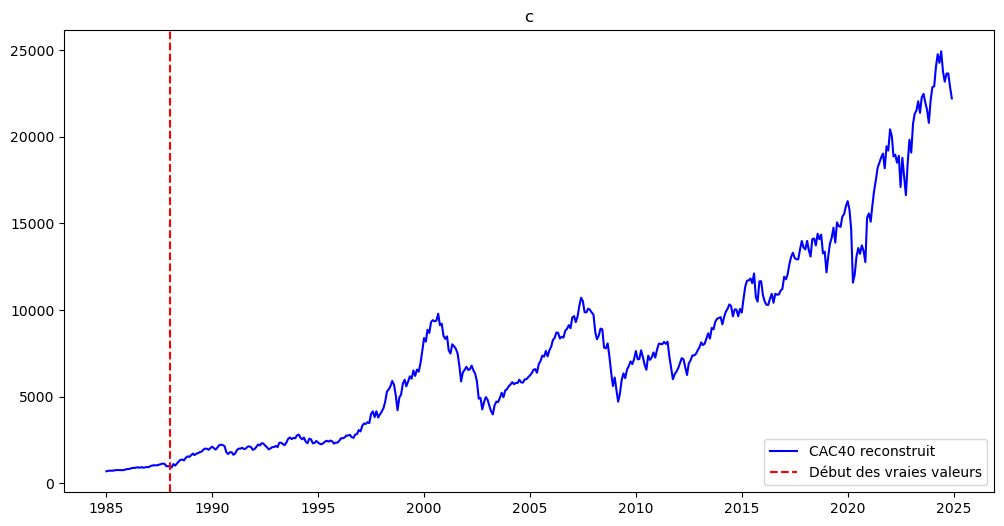

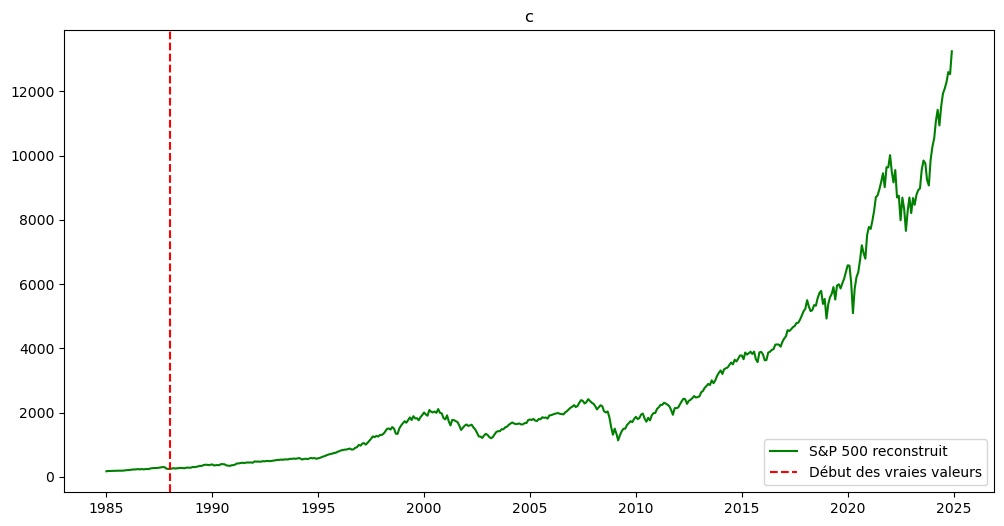

In [168]:
# Afichage du CAC 40 avec le backfill
plt.figure(figsize=(12,6))
plt.plot(df.index, df["CAC40_TR_combined"], label="CAC40 reconstruit", color="blue")
plt.axvline(x=pd.to_datetime(first_full_date), color="red", linestyle="--", label="Début des vraies valeurs")
plt.legend()
plt.title("c")
plt.show()

# Afichage du S&P500 avec le backfill
plt.figure(figsize=(12,6))
plt.plot(df.index, df["SP500_TR_combined"], label="S&P 500 reconstruit", color="green")
plt.axvline(x=pd.to_datetime(first_full_date), color="red", linestyle="--", label="Début des vraies valeurs")
plt.legend()
plt.title("c")
plt.show()

In [169]:
df_to_export = df[["SP500_TR_combined","CAC40_TR_combined","WGBI_TR"]].rename(columns={'SP500_TR_combined': 'SP500_TR',"CAC40_TR_combined": "CAC40_TR"})

print(df_to_export)

df_to_export.to_csv(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites\data\final\DataFrame_backfilled.csv", index=True, encoding="utf-8")

                SP500_TR      CAC40_TR       WGBI_TR
Date                                                
1985-01-01    172.176132    692.288669  10000.000000
1985-02-01    180.194935    720.457778  10235.623791
1985-03-01    181.992612    726.738050   9832.991278
1985-04-01    182.598183    728.870481  10019.526779
1985-05-01    183.032920    730.405192  10250.878162
...                  ...           ...           ...
2024-08-01  12086.490234  23179.092370  55630.313495
2024-09-01  12292.099609  23646.248645  56093.077188
2024-10-01  12598.030273  23654.766305  55534.603307
2024-11-01  12533.190430  22857.802261  57289.947892
2024-12-01  13245.660156  22211.844867  56892.306595

[480 rows x 3 columns]
